In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_rows', None)    # None means no limit
pd.set_option('display.max_columns', None)    # None means no limit
from functions_variables import *
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.dates as mdates
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import pickle
from xgboost import XGBClassifier
from ydata_profiling import ProfileReport
from sklearn.metrics import f1_score
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance


In [3]:
# Load data
df = pd.read_csv('../data/preprocessed/macro_finance_data_2014_2023.csv')
df.tail()

,Date,WTI Price,Natural Gas Price,Aluminum Price,Copper Price,Gold Price,Platinum Price,Silver Price,Lumber Price,Interest_Rate,GDP,CPI,HPI,Trade Balance,Unemployment,Wholesale Trade,US_GDP,Housing starts,DAX,STOXX 50,FTSE 100,NASDAQ,Nikkei 225,Russell 2000,S&P 500,TSX,CADJPY,EURCAD,GBPCAD,USDCAD,10 YR Bond Yield
3221,2024-02-19,78.11,1.558,2197.0,3.8110,2027.5,905.65,23.003,565.0,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17092.26,4763.07,7728.50,15775.65,38470.38,2032.74,5005.57,21255.61,111.27,1.4536,1.6985,1.3488,3.1
3222,2024-02-20,78.18,1.576,2193.5,3.8675,2039.8,914.30,23.136,556.5,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17068.43,4760.28,7719.21,15630.78,38363.61,2004.14,4975.51,21217.53,110.89,1.4606,1.7060,1.3520,3.1
3223,2024-02-21,77.91,1.773,2219.5,3.8750,2034.3,889.60,22.874,560.5,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17118.12,4775.31,7662.51,15580.87,38262.16,1994.74,4981.80,21172.38,111.27,1.4608,1.7062,1.3505,3.1
3224,2024-02-22,78.61,1.732,2198.0,3.8970,2030.7,905.50,22.784,564.5,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17370.45,4855.36,7684.49,16041.62,39098.68,2013.84,5087.03,21318.08,111.64,1.4590,1.7066,1.3481,3.1
3225,2024-02-23,76.49,1.603,2180.0,3.8800,2049.4,909.60,22.982,564.5,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17419.33,4872.57,7706.28,15996.82,39098.68,2016.69,5088.80,21413.15,111.42,1.4610,1.7112,1.3505,3.1


### Create Target Variable for TSX Index if Index has Increased from the Prior Day

In [4]:
df['Index Up'] = df['TSX'] > df['TSX'].shift(1)
df.head(10)

,Date,WTI Price,Natural Gas Price,Aluminum Price,Copper Price,Gold Price,Platinum Price,Silver Price,Lumber Price,Interest_Rate,GDP,CPI,HPI,Trade Balance,Unemployment,Wholesale Trade,US_GDP,Housing starts,DAX,STOXX 50,FTSE 100,NASDAQ,Nikkei 225,Russell 2000,S&P 500,TSX,CADJPY,EURCAD,GBPCAD,USDCAD,10 YR Bond Yield,Index Up
0,2014-01-01,98.70,4.232,1840.25,3.3815,1225.2,1377.05,20.128,353.3,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9400.04,3059.93,6717.91,4143.07,15908.88,1150.72,1831.98,13594.19,98.88,1.4640,1.7634,1.0644,2.74,False
1,2014-01-02,95.44,4.321,1840.25,3.3815,1225.2,1402.30,20.128,353.3,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9400.04,3059.93,6717.91,4143.07,15908.88,1150.72,1831.98,13594.19,98.18,1.4589,1.7558,1.0671,2.74,False
2,2014-01-03,93.96,4.304,1840.25,3.3550,1238.6,1412.45,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False
3,2014-01-04,93.96,4.304,1840.25,3.3550,1238.6,1412.45,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False
4,2014-01-05,93.96,4.304,1840.25,3.3550,1238.6,1407.30,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False
5,2014-01-06,93.43,4.306,1840.25,3.3595,1238.0,1415.60,20.103,352.0,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9428.00,3069.16,6730.73,4113.68,15908.88,1147.16,1826.77,13495.54,97.81,1.4522,1.7481,1.0655,2.72,False
6,2014-01-07,93.67,4.299,1840.25,3.3595,1229.6,1413.65,19.787,354.2,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9506.20,3110.96,6755.45,4153.18,15814.37,1157.63,1837.88,13596.93,97.18,1.4658,1.7658,1.0766,2.67,True
7,2014-01-08,92.33,4.216,1840.25,3.3425,1225.5,1416.65,19.539,356.0,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9497.84,3110.66,6721.78,4165.61,16121.45,1157.46,1837.49,13614.63,96.91,1.4688,1.7795,1.0819,2.72,True
8,2014-01-09,91.66,4.005,1840.25,3.2990,1229.4,1418.90,19.683,365.5,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9421.61,3090.26,6691.34,4156.19,15880.33,1158.35,1838.13,13629.41,96.70,1.4751,1.7866,1.0840,2.68,True
9,2014-01-10,92.72,4.053,1840.25,3.3415,1246.9,1437.35,20.223,362.2,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9473.24,3104.15,6739.94,4174.66,15912.06,1164.53,1842.37,13747.52,95.60,1.4892,1.7956,1.0895,2.56,True


## For EDA set the date as the index to leverage time series specific methods for understanding the data

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


In [6]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['DayofWeek'] = df.index.dayofweek
df.tail()

,WTI Price,Natural Gas Price,Aluminum Price,Copper Price,Gold Price,Platinum Price,Silver Price,Lumber Price,Interest_Rate,GDP,CPI,HPI,Trade Balance,Unemployment,Wholesale Trade,US_GDP,Housing starts,DAX,STOXX 50,FTSE 100,NASDAQ,Nikkei 225,Russell 2000,S&P 500,TSX,CADJPY,EURCAD,GBPCAD,USDCAD,10 YR Bond Yield,Index Up,Year,Month,Day,DayofWeek
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-02-19,78.11,1.558,2197.0,3.8110,2027.5,905.65,23.003,565.0,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17092.26,4763.07,7728.50,15775.65,38470.38,2032.74,5005.57,21255.61,111.27,1.4536,1.6985,1.3488,3.1,False,2024,2,19,0
2024-02-20,78.18,1.576,2193.5,3.8675,2039.8,914.30,23.136,556.5,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17068.43,4760.28,7719.21,15630.78,38363.61,2004.14,4975.51,21217.53,110.89,1.4606,1.7060,1.3520,3.1,False,2024,2,20,1
2024-02-21,77.91,1.773,2219.5,3.8750,2034.3,889.60,22.874,560.5,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17118.12,4775.31,7662.51,15580.87,38262.16,1994.74,4981.80,21172.38,111.27,1.4608,1.7062,1.3505,3.1,False,2024,2,21,2
2024-02-22,78.61,1.732,2198.0,3.8970,2030.7,905.50,22.784,564.5,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17370.45,4855.36,7684.49,16041.62,39098.68,2013.84,5087.03,21318.08,111.64,1.4590,1.7066,1.3481,3.1,True,2024,2,22,3
2024-02-23,76.49,1.603,2180.0,3.8800,2049.4,909.60,22.982,564.5,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17419.33,4872.57,7706.28,15996.82,39098.68,2016.69,5088.80,21413.15,111.42,1.4610,1.7112,1.3505,3.1,True,2024,2,23,4


In [ ]:
with open('../data/models/baseline2.pkl', 'wb') as file:
    pickle.dump(df, file)

In [7]:
# create a dataframe that only includes the weekdays
# commodities and currency are traded on weekend, but the index is only traded during the week, therefore the number of False values will be present 
# if the weekends are included and distort the percentage of index up calculations
df = df[df['DayofWeek'] < 5]
df.tail(10)

,WTI Price,Natural Gas Price,Aluminum Price,Copper Price,Gold Price,Platinum Price,Silver Price,Lumber Price,Interest_Rate,GDP,CPI,HPI,Trade Balance,Unemployment,Wholesale Trade,US_GDP,Housing starts,DAX,STOXX 50,FTSE 100,NASDAQ,Nikkei 225,Russell 2000,S&P 500,TSX,CADJPY,EURCAD,GBPCAD,USDCAD,10 YR Bond Yield,Index Up,Year,Month,Day,DayofWeek
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-02-12,76.92,1.768,2227.0,3.7240,2033.0,897.10,22.767,552.5,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17037.35,4746.35,7573.69,15942.54,36897.42,2045.26,5021.84,21067.30,111.01,1.4485,1.6985,1.3448,3.1,True,2024,2,12,0
2024-02-13,77.87,1.689,2225.5,3.7110,2007.2,878.90,22.154,552.5,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,16880.83,4689.28,7512.28,15655.60,37963.97,1964.17,4953.17,20584.97,111.14,1.4520,1.7073,1.3563,3.1,False,2024,2,13,1
2024-02-14,76.64,1.609,2235.5,3.7000,2004.3,897.30,22.387,559.0,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,16945.48,4709.22,7568.40,15859.15,37703.32,2012.10,5000.62,20889.40,111.16,1.4527,1.7016,1.3541,3.1,True,2024,2,14,2
2024-02-15,78.03,1.581,2224.5,3.7580,2014.9,905.20,22.951,555.5,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17046.69,4743.17,7597.53,15906.17,38157.94,2061.48,5029.73,21222.69,111.32,1.4501,1.6963,1.3463,3.1,True,2024,2,15,3
2024-02-16,79.19,1.609,2218.0,3.8385,2024.1,913.50,23.475,564.0,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17117.44,4765.65,7711.71,15775.65,38487.24,2032.74,5005.57,21255.61,111.37,1.4528,1.6987,1.3484,3.1,True,2024,2,16,4
2024-02-19,78.11,1.558,2197.0,3.8110,2027.5,905.65,23.003,565.0,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17092.26,4763.07,7728.50,15775.65,38470.38,2032.74,5005.57,21255.61,111.27,1.4536,1.6985,1.3488,3.1,False,2024,2,19,0
2024-02-20,78.18,1.576,2193.5,3.8675,2039.8,914.30,23.136,556.5,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17068.43,4760.28,7719.21,15630.78,38363.61,2004.14,4975.51,21217.53,110.89,1.4606,1.7060,1.3520,3.1,False,2024,2,20,1
2024-02-21,77.91,1.773,2219.5,3.8750,2034.3,889.60,22.874,560.5,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17118.12,4775.31,7662.51,15580.87,38262.16,1994.74,4981.80,21172.38,111.27,1.4608,1.7062,1.3505,3.1,False,2024,2,21,2
2024-02-22,78.61,1.732,2198.0,3.8970,2030.7,905.50,22.784,564.5,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17370.45,4855.36,7684.49,16041.62,39098.68,2013.84,5087.03,21318.08,111.64,1.4590,1.7066,1.3481,3.1,True,2024,2,22,3


In [ ]:
#group index up by month
grouped = df.groupby(['Year','Month'])['Index Up'].sum()

In [ ]:
#calculate the number of trading days per month
trading_days = df.groupby(['Year', 'Month']).size()

# Calculate the percentage of Index Up for each month relative to the total
percentage_index_up = (grouped / trading_days) * 100

# Combine the results into a DataFrame
result = pd.DataFrame({
    'Index Up Sum': grouped,
    'Total Trading Days': trading_days,
    'Percentage of Index Up': percentage_index_up
})
result

In [ ]:
result.describe()

In [ ]:
# Calculate the average percentage of index up per trading day for each month for all 10 years combined
month_grouped = result.groupby('Month')['Percentage of Index Up'].mean()

In [ ]:
month_grouped.mean()

In [ ]:
# Calculate the average percentage of index up per trading day for each year for all 10 years
year_grouped = result.groupby('Year')['Percentage of Index Up'].mean()

In [ ]:
year_grouped.mean()

In [ ]:
# To determine if there are any specifc days on which the stock index goes up
day_grouped = df.groupby('Day')['Index Up'].sum()
day_grouped.sort_values(ascending=False)

### Date-Time Components Conclusion
<p>The analysis didn't provide any meaningful patterns or trends involved. The index increased slightly more on a daily basis than going down at an average of 52.4% of the time. The maximum month where the index went up was 82.6% of the time in 2019 and the minimum was 2017 September at 27%. During the Covid Pandemic the market actually performed better in 2019-2021 with the index increasing greater than 55% of the time. Monthly fluctions occured, but on average each year the results are similar across all 10 years. It appears that the middle of the month has higher than normal times where the index went up, with the number of days being the highest for those days.</p>

## Time Series Graphing

In [ ]:
column_list = df.columns[:-5]

In [ ]:
for column in column_list:
    plot_line_chart(df.index,df[column], column)

## Correlation

In [ ]:
# Correlation for all features
correlation_matrix = df.corr()
correlation_matrix

In [ ]:
# Correlation with just the target 
correlation_matrix['TSX']

In [ ]:
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.show()


In [ ]:
# Correlation for all features
correlation_matrix = df.corr()
correlation_matrix

# Identify upper triangle of the correlation matrix
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Drop those features with correlation greater than 0.9
# Although TSX has correlation greater than 0.9 it will not be dropped
to_drop.remove('EMA')
to_drop.remove('TSX')
df_reduced = df.drop(columns=to_drop)

# Print the results
print(f"Features dropped: {to_drop}")
print(f"Remaining features: {df_reduced.columns.tolist()}")
print(f"Number of features remaining: {df_reduced.shape[1]}")

## IMPORT BASELINE DATAFRAME

In [ ]:
with open('../data/models/baseline2.pkl', 'rb') as file:
    df = pickle.load(file)

In [ ]:
df.head()

# Feature Engineering

## Time-based Features: Exponential Moving Average
<p>An Exponential Moving Average (EMA) is a type of moving average that places a greater weight and significance on the most recent data points. It is commonly used in time series analysis, especially in financial markets, to smooth out data and identify trends more effectively than a simple moving average (SMA).</p>

In [12]:
n = 20 # period for the EMA. Used to track the trend of a stock over approximately one month, which is inline with other economic features.

df['EMA'] = df['TSX'].ewm(span=n, adjust=False).mean()
df.head()

,WTI Price,Natural Gas Price,Aluminum Price,Copper Price,Gold Price,Platinum Price,Silver Price,Lumber Price,Interest_Rate,GDP,CPI,HPI,Trade Balance,Unemployment,Wholesale Trade,US_GDP,Housing starts,DAX,STOXX 50,FTSE 100,NASDAQ,Nikkei 225,Russell 2000,S&P 500,TSX,CADJPY,EURCAD,GBPCAD,USDCAD,10 YR Bond Yield,Index Up,Year,Month,Day,DayofWeek,EMA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01,98.70,4.232,1840.25,3.3815,1225.2,1377.05,20.128,353.3,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9400.04,3059.93,6717.91,4143.07,15908.88,1150.72,1831.98,13594.19,98.88,1.4640,1.7634,1.0644,2.74,False,2014,1,1,2,13594.190000
2014-01-02,95.44,4.321,1840.25,3.3815,1225.2,1402.30,20.128,353.3,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9400.04,3059.93,6717.91,4143.07,15908.88,1150.72,1831.98,13594.19,98.18,1.4589,1.7558,1.0671,2.74,False,2014,1,2,3,13594.190000
2014-01-03,93.96,4.304,1840.25,3.3550,1238.6,1412.45,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False,2014,1,3,4,13589.872857
2014-01-06,93.43,4.306,1840.25,3.3595,1238.0,1415.60,20.103,352.0,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9428.00,3069.16,6730.73,4113.68,15908.88,1147.16,1826.77,13495.54,97.81,1.4522,1.7481,1.0655,2.72,False,2014,1,6,0,13580.888776
2014-01-07,93.67,4.299,1840.25,3.3595,1229.6,1413.65,19.787,354.2,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9506.20,3110.96,6755.45,4153.18,15814.37,1157.63,1837.88,13596.93,97.18,1.4658,1.7658,1.0766,2.67,True,2014,1,7,1,13582.416511


In [13]:
# Computing the difference between consecutive EMA values, which essentially give the slope of the EMA
df['EMA Slope'] = df['EMA'].diff()
df.head()

,WTI Price,Natural Gas Price,Aluminum Price,Copper Price,Gold Price,Platinum Price,Silver Price,Lumber Price,Interest_Rate,GDP,CPI,HPI,Trade Balance,Unemployment,Wholesale Trade,US_GDP,Housing starts,DAX,STOXX 50,FTSE 100,NASDAQ,Nikkei 225,Russell 2000,S&P 500,TSX,CADJPY,EURCAD,GBPCAD,USDCAD,10 YR Bond Yield,Index Up,Year,Month,Day,DayofWeek,EMA,EMA Slope
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01,98.70,4.232,1840.25,3.3815,1225.2,1377.05,20.128,353.3,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9400.04,3059.93,6717.91,4143.07,15908.88,1150.72,1831.98,13594.19,98.88,1.4640,1.7634,1.0644,2.74,False,2014,1,1,2,13594.190000,NaN
2014-01-02,95.44,4.321,1840.25,3.3815,1225.2,1402.30,20.128,353.3,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9400.04,3059.93,6717.91,4143.07,15908.88,1150.72,1831.98,13594.19,98.18,1.4589,1.7558,1.0671,2.74,False,2014,1,2,3,13594.190000,0.000000
2014-01-03,93.96,4.304,1840.25,3.3550,1238.6,1412.45,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False,2014,1,3,4,13589.872857,-4.317143
2014-01-06,93.43,4.306,1840.25,3.3595,1238.0,1415.60,20.103,352.0,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9428.00,3069.16,6730.73,4113.68,15908.88,1147.16,1826.77,13495.54,97.81,1.4522,1.7481,1.0655,2.72,False,2014,1,6,0,13580.888776,-8.984082
2014-01-07,93.67,4.299,1840.25,3.3595,1229.6,1413.65,19.787,354.2,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9506.20,3110.96,6755.45,4153.18,15814.37,1157.63,1837.88,13596.93,97.18,1.4658,1.7658,1.0766,2.67,True,2014,1,7,1,13582.416511,1.527736


In [14]:
# EMA divided by the closing price of the TSX index
df['EMA/Close'] = df['EMA'] / df['TSX']
df.head()

,WTI Price,Natural Gas Price,Aluminum Price,Copper Price,Gold Price,Platinum Price,Silver Price,Lumber Price,Interest_Rate,GDP,CPI,HPI,Trade Balance,Unemployment,Wholesale Trade,US_GDP,Housing starts,DAX,STOXX 50,FTSE 100,NASDAQ,Nikkei 225,Russell 2000,S&P 500,TSX,CADJPY,EURCAD,GBPCAD,USDCAD,10 YR Bond Yield,Index Up,Year,Month,Day,DayofWeek,EMA,EMA Slope,EMA/Close
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01,98.70,4.232,1840.25,3.3815,1225.2,1377.05,20.128,353.3,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9400.04,3059.93,6717.91,4143.07,15908.88,1150.72,1831.98,13594.19,98.88,1.4640,1.7634,1.0644,2.74,False,2014,1,1,2,13594.190000,NaN,1.000000
2014-01-02,95.44,4.321,1840.25,3.3815,1225.2,1402.30,20.128,353.3,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9400.04,3059.93,6717.91,4143.07,15908.88,1150.72,1831.98,13594.19,98.18,1.4589,1.7558,1.0671,2.74,False,2014,1,2,3,13594.190000,0.000000,1.000000
2014-01-03,93.96,4.304,1840.25,3.3550,1238.6,1412.45,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False,2014,1,3,4,13589.872857,-4.317143,1.003027
2014-01-06,93.43,4.306,1840.25,3.3595,1238.0,1415.60,20.103,352.0,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9428.00,3069.16,6730.73,4113.68,15908.88,1147.16,1826.77,13495.54,97.81,1.4522,1.7481,1.0655,2.72,False,2014,1,6,0,13580.888776,-8.984082,1.006324
2014-01-07,93.67,4.299,1840.25,3.3595,1229.6,1413.65,19.787,354.2,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9506.20,3110.96,6755.45,4153.18,15814.37,1157.63,1837.88,13596.93,97.18,1.4658,1.7658,1.0766,2.67,True,2014,1,7,1,13582.416511,1.527736,0.998933


In [ ]:
# The difference between the EMA and the TSX index. If TSX is greater than moving average value will be positive.
df['EMA Divergence'] = df['TSX'] - df['EMA']
df.head()

## Technical Indicators: Relative Strength Index (RSI)
<p>The Relative Strength Index (RSI) is a momentum oscillator used in technical analysis that measures the speed and change of price movements. It is typically used to identify overbought or oversold conditions in a market. The RSI oscillates between 0 and 100, making it easy to interpret and apply in various trading strategies.</p>
<p>Below 30: The asset is generally considered oversold, indicating that it may be undervalued and due for a rebound. </p>
<p>Above 70: The asset is generally considered overbought, indicating that it may be overvalued and due for a correction or pullback.</p>

In [15]:
df['RSI'] = calculate_rsi(df['TSX'])

## Technical Indicators: Moving Average Convergence Divergence (MACD)

In [16]:
# Calculate the MACD line
df['MACD'] = df['TSX'].ewm(span=12, adjust=False).mean() - df['TSX'].ewm(span=26, adjust=False).mean()

In [17]:
# Calculate the Signal line (9-day EMA of MACD) 
df['Signal Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

In [18]:
# Calculate the MACD Histogram 
df['MACD Histogram'] = df['MACD'] - df['Signal Line']

In [19]:
# Drop the unnecessary MACD line and Signal line columns from features
df = df.drop(columns=['MACD', 'Signal Line'])

## Price Transformations: Daily Returns and Volatility
<p>Understanding the price fluctuations of a financial asset and measuring the risk associated with the asset on a daily basis.</p>

In [20]:
# Calculate Daily Returns
df['Daily Return'] = df['TSX'].pct_change()  

# Calculate the Rolling Standard Deviation of Daily Returns
df['Daily Volatility'] = df['Daily Return'].rolling(window=14).std()

df = df.drop(columns=['Daily Return']) # Simple returns is the same as the target variable, positive return equals index up, therefore will not include

In [ ]:
print(df[['TSX', 'Daily Volatility']].tail())

In [21]:
# Fill all NaN values with zero for EMA, RSI and Volatility
df = df.fillna(0)

Remove correlation once EDA complete

In [23]:
# Correlation for all features
correlation_matrix = df.corr()
correlation_matrix

# Identify upper triangle of the correlation matrix
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Drop those features with correlation greater than 0.9
# Although TSX has correlation greater than 0.9 it will not be dropped
#to_drop.remove('EMA')
to_drop.remove('TSX')
df_reduced = df.drop(columns=to_drop)

# Print the results
print(f"Features dropped: {to_drop}")
print(f"Remaining features: {df_reduced.columns.tolist()}")
print(f"Number of features remaining: {df_reduced.shape[1]}")

Features dropped: ['Copper Price', 'HPI', 'Trade Balance', 'Wholesale Trade', 'US_GDP', 'STOXX 50', 'NASDAQ', 'Nikkei 225', 'Russell 2000', 'S&P 500', 'Year', 'EMA']
Remaining features: ['WTI Price', 'Natural Gas Price', 'Aluminum Price', 'Gold Price', 'Platinum Price', 'Silver Price', 'Lumber Price', 'Interest_Rate', 'GDP', 'CPI', 'Unemployment', 'Housing starts', 'DAX', 'FTSE 100', 'TSX', 'CADJPY', 'EURCAD', 'GBPCAD', 'USDCAD', '10 YR Bond Yield', 'Index Up', 'Month', 'Day', 'DayofWeek', 'EMA Slope', 'EMA/Close', 'RSI', 'MACD Histogram', 'Daily Volatility']
Number of features remaining: 29


### Generate EDA Report

In [ ]:
# Generate the profiling report with time-series mode enabled and sorted by variable type
profile = ProfileReport(df, tsmode=True, title="Time-Series Data Profiling Report")

# Save the report to an HTML file
profile.to_file("your_report.html")

In [ ]:
df_reduced.info()

## Time-Series-Split Data for Time Series Data Set

In [24]:
X = df_reduced.drop(columns=['Index Up'])
y = df_reduced['Index Up']

In [25]:
tss = TimeSeriesSplit(n_splits=3)

In [26]:
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) # maintain column names
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

### Processed Data for Different Iterations

In [ ]:
X_train_scaled.to_csv('../data/processed/X_train_scaled.csv', index=False)
X_test_scaled.to_csv('../data/processed/X_test_scaled.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

### Final Dataset

In [ ]:
X_train.to_csv('../data/final/X_train.csv', index=False)
X_test.to_csv('../data/final/X_test.csv', index=False)

X_train_scaled.to_csv('../data/final/X_train_scaled.csv', index=False)
X_test_scaled.to_csv('../data/final/X_test_scaled.csv', index=False)
y_train.to_csv('../data/final/y_train.csv', index=False)
y_test.to_csv('../data/final/y_test.csv', index=False)

### Scaler Used to Scale Data to be Used to Unscale Later

In [ ]:
with open('../data/final/scalar.pkl', 'wb') as file:
    pickle.dump(scaler, file)

## Recursive Feature Elimination - Logistic Regression Model

In [ ]:
# Initialize Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Initialize RFE with Logistic Regression and the number of features to select
rfe = RFE(estimator=log_reg, n_features_to_select=25)

# Fit RFE on the scaled training data
rfe.fit(X_train_scaled, y_train)

# Get the mask of selected features
selected_features = rfe.support_

# Convert boolean mask to the list of selected feature names
selected_feature_names = X_train.columns[selected_features]

# Filter the training and test data with the selected features
X_train_selected = X_train[selected_feature_names]
X_test_selected = X_test[selected_feature_names]

# Fit Logistic Regression on the selected features
log_reg.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test_selected)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multiclass

# Display results
print("Selected Features:", selected_feature_names.tolist())
print("F1 Score:", f1)

Number of features (F1 Score):

17 - 0.644

20 - 0.656

25 - 0.636

## Recursive Feature Elimination - XGBoost Model

In [ ]:
model = XGBClassifier(random_state=42, eval_metric='mlogloss')

# Create an RFE object, specifying the model and the number of features to select
rfe = RFE(estimator=model, n_features_to_select=20)

# Fit the RFE model on the data
rfe.fit(X_train_scaled, y_train)

# Get the rankings of the features
ranking = rfe.ranking_
selected_features = X_train_scaled.columns[rfe.support_]

print(f"Feature Rankings: {ranking}")
print(f"Selected Features: {selected_features.tolist()}")

X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Train a model on the selected features
model.fit(X_train_rfe, y_train)
y_pred = model.predict(X_test_rfe)
f1 = f1_score(y_test, y_pred, average='binary')
print("Model F1 Score with Selected Features:", f1)

The XGBoost RFE technique yielded the best results so far with an F1 score of 0.718, which is better than the previous benchmark of 0.71. Using the selected features above, we will see how the hyper paramater tuning will help improve the model performance.

Number of features (F1 Score):

17 - 0.708

20 - 0.713

25 - 0.684



## Feature Importance Using Random Forest Classifier

In [ ]:

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X_train_scaled, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance using Random Forest')
plt.gca().invert_yaxis() # To display the most important feature at the top
plt.show()

There are several features that seem to be unimportant with importance values below the others using the Random Forest model feature importance selection, but I decided to test eliminating features below the DayofWeek to see how the model performs. After removing the below features I ran the dataset through all the models again , but the models didn't improve above the benchmark of 0.73 from Logistic Regression, but had a F1 Score of 0.71 from the Logistic Regression model.

In [ ]:
X_train_scaled = X_train_scaled.drop(['Month', 'GDP', 'Housing starts','Interest_Rate', 'Unemployment', 'CPI'], axis=1)

In [ ]:
X_train_scaled.to_csv('../data/processed/X_train_scaled.csv', index=False)
X_test_scaled.to_csv('../data/processed/X_test_scaled.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

## Feature Importance Using XGBoost Classifier

In [ ]:
# Initialize XGBClassifier
xgb_model = xgb.XGBClassifier(eval_metric='logloss')

# Fit the model to the training data
xgb_model.fit(X_train_scaled, y_train)

# Get feature importances using the 'Gain' method
feature_importances = xgb_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print the DataFrame
print(feature_importance_df)

# Visualize feature importances using XGBoost's built-in plot_importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, importance_type='gain')  # Choose from 'weight', 'gain', 'cover'
plt.title('Feature Importance by Gain')
plt.show()

There are no clear features that are unimportant with importance values much below the others using the XGBoost model feature importance selection, but I decided to test eliminating features below the TSX importance value of 1.2 to see how the model performs. After removing the below features and running the dataset through all the models againg the Logistic Regression model improved above the benchmark of 0.73 to an F1 Score of 0.74.

In [ ]:
X_train_scaled = X_train_scaled.drop(['DayofWeek','DAX','Lumber Price', 'GBPCAD', 'CADJPY'], axis=1)

In [ ]:
X_test_scaled = X_test_scaled.drop(['DayofWeek','DAX','Lumber Price', 'GBPCAD', 'CADJPY'], axis=1)

In [ ]:
X_train_scaled.to_csv('../data/processed/X_train_scaled.csv', index=False)
X_test_scaled.to_csv('../data/processed/X_test_scaled.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

In [ ]:
X_test_scaled.columns

### Line Chart of TSX Index Train and Test Set Data

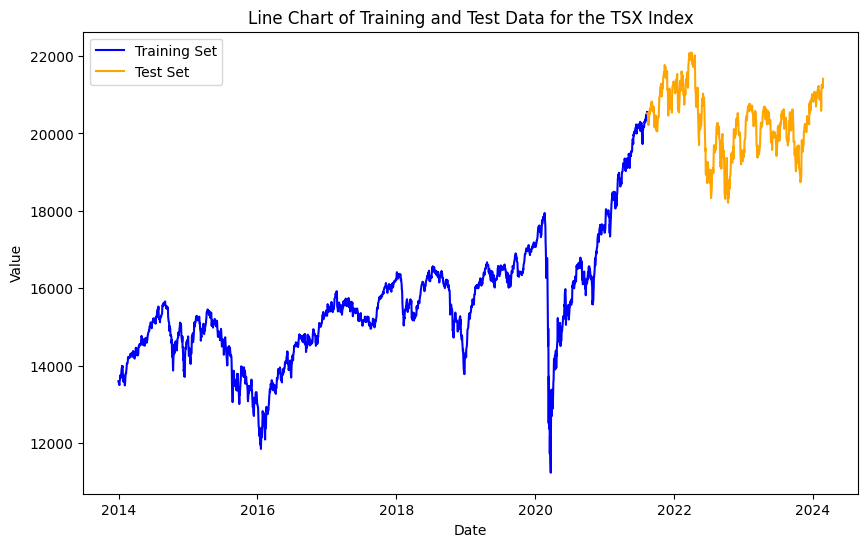

In [34]:
plt.figure(figsize=(10, 6))

# Plot the training set
sns.lineplot(x=X_train.index, y=X_train['TSX'], color='blue', label='Training Set')

# Plot the test set
sns.lineplot(x=X_test.index, y=X_test['TSX'], color='orange', label='Test Set')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Line Chart of Training and Test Data for the TSX Index')
plt.legend()
